# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [22]:
import os, sys, wave, struct

import numpy as np
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio

import pyaudio
import time
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


## Functions

In [3]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [4]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [6]:
wavefile = load_sound(sound)
print(wavefile.getparams())

(1, 2, 48000, 805733, 'NONE', 'not compressed')


In [7]:
play = False
if play :
    play_sound(sound) 

In [8]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [9]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

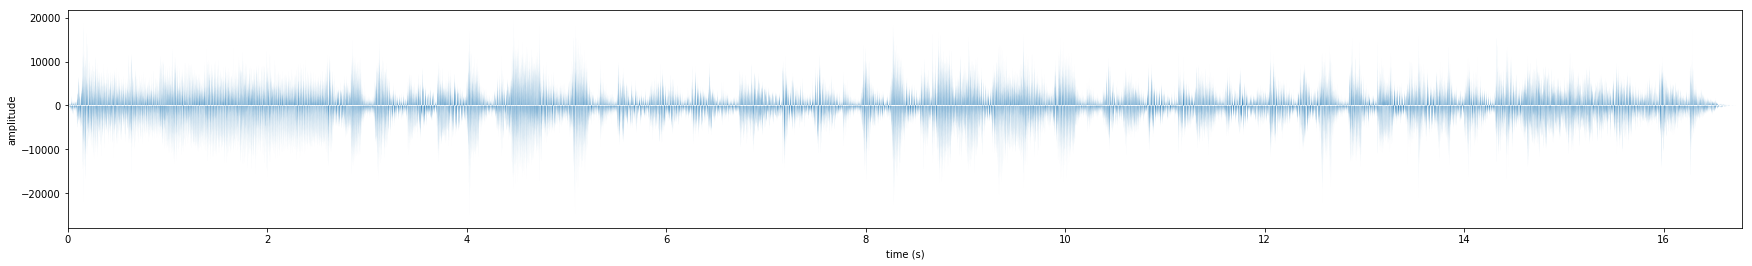

In [10]:
plot_sound(x, times)

In [11]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

In [12]:
N = x.shape[0] # % longueur du signal
Nw = 512
w = np.hanning(Nw) # définition de la fenetre d'analyse
ws = w.copy; # définition de la fenêtre de synthèse
R = Nw/4 # incrément sur les temps d'analyse, appelé hop size, t_a=uR
M = 512 # ordre de la tfd
L = M/2+1
affich = 1 ; # pour affichage du spectrogramme, 0 pour
             # pour faire analyse/modif/synthèse sans affichage
             # note: cf. spectrogram sous Matlab
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

In [13]:
for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

In [14]:
def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-55, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

In [15]:
def make_times(Fs,x):
  timestep = 1/float(Fs)
  times = np.arange(len(x))*timestep
  return times

1634768721.28
1634768723.62


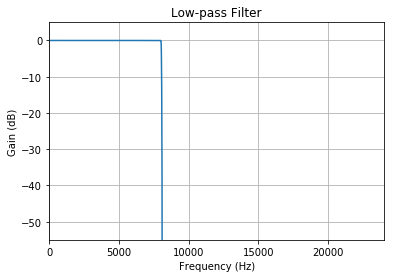

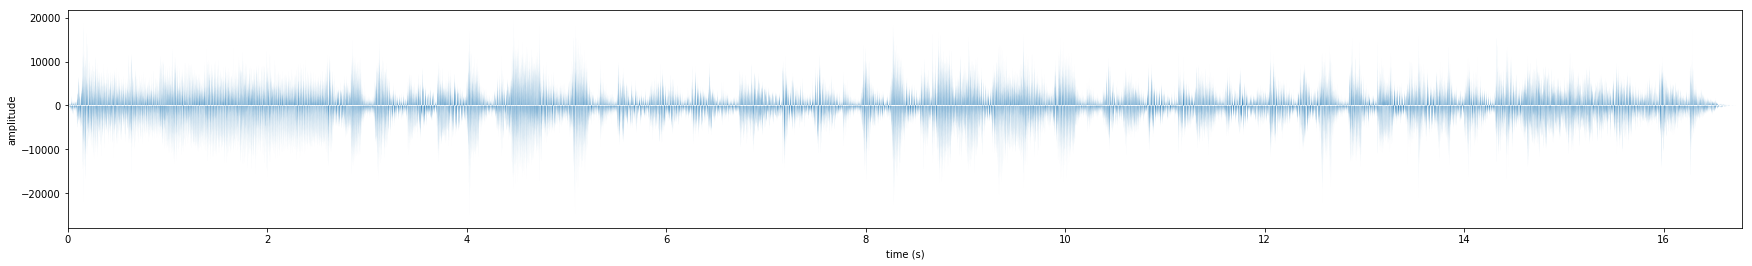

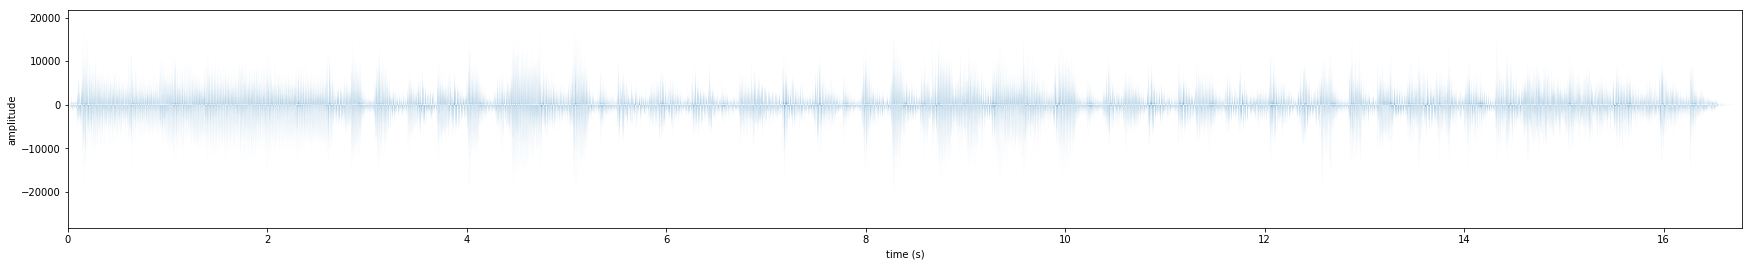

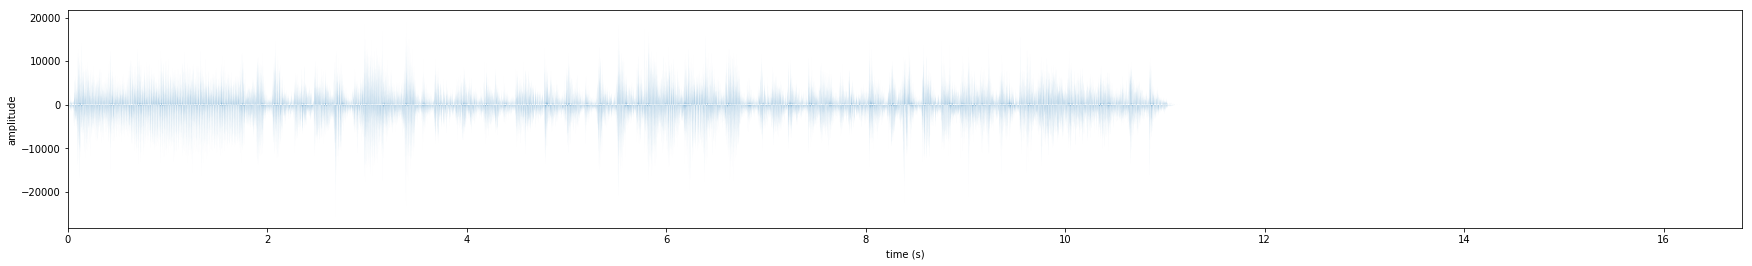

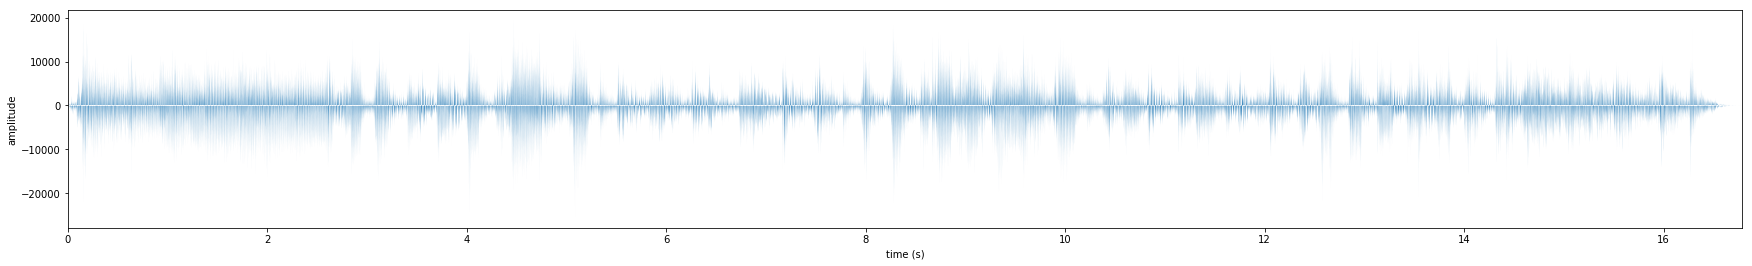

('times48 is of length ', 805733, ' and times32 is of length ', 537155)


In [25]:
#Question 1,2 -- Conversion functions, Filter synthesis and Plots
data = [1,1,1,1,1,1]

def downsampling(data, n):
  L = (len(data)-1)/n + 1
  sound_2 = []
  for i in range(L):
    sound_2.append(data[n*i])
  return sound_2
    
#downs = downsampling(data, 2)
#print(downs)
 
def upsampling(data, n):
  L=len(data)  
  sound_2 = [0]*(n*(L-1)+1)
  for i in range(0,L):
    sound_2[i*n]=data[i]
  return sound_2

#ups = upsampling(data,3)
#print(ups)

# [IMPORTANT NOTE] : The min function has a very strange way of doing the min :
# When given min(1/4,1/6), it will give back 0. You can try it ! This is why I use 2.0 and 3.0 !
# print(min(1/4,1/6))

#Now for the filter :
#We use the Remez method, already implemented in Python to craft the filter h

up,down = 2.0,3.0                       # In order to get the 2/3 conversing ratio. A mistake happened with the min function.
mins = min((1/(2*up)),1/((2*down)))     # For the cutoff frequency
fs = 48000.0                            # Sample rate, Hz
cutoff = fs*mins    # This cutoff is calculated via the course formula : min(1/2L,1/2M) with L and M being up/downsampling ratios.
trans_width = 100                       # Width of transition band from the "pass" frequencies to the "stop" band.
filtersize = 2000                       # Size of the FIR filter. 1300 is a good compromise to have the 50 dB difference and a fast computation.
#However my code yields the best results upon choosing filtersize > 2000. The computation is slower, but the results are far better.
#I know 2000 is a lot ! Even 400 is a lot, with 256 usually it suffices but I couldn't get good results at low FIR levels.

print(time.time())
remez_result = signal.remez(filtersize, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
w, h = signal.freqz(remez_result, [1], worN=2000)
plot_response(fs, w, h, "Low-pass Filter")

#Now we have that low-pass filter and up/downsampling functions, we can do the whole chain : 
y = upsampling(x,2)                        #start with the upsampling
y_filtered = signal.lfilter(h,[1],y)*up      #do the filtering with a convolution, we add the "up" (*L factor) directly.
x_hat = downsampling(y_filtered,3)         #then finish with the downsampling. 

print(time.time()) #For question 4

#Now we just thave to reshape x_hat as it is too short compared to the previous "times" abscissa. (Bcs of the conversion) 
#I made a function specifically to craft a times list for a given sampling frequency fs. I'll use times32 here.

times32 = make_times(32000,x_hat)
times48 = make_times(48000,x)

#We now want to hear the converted sound and plot it :
plot_sound(x,times48)       #To compare
plot_sound(x_hat,times32)   #And they look almost exactly the same ! The difference is in the quality of the filter.

Ltimes,Lx_hat = len(times48),len(x_hat)
for i in range(Lx_hat,Ltimes):
  x_hat.append(0)
plot_sound(x_hat,times48)   #To compare with the actual length 

resampled_x = signal.resample_poly(x,2,3)[:-1]    #All but the last element as it is one number too long
plot_sound(resampled_x,times32)                   #Check with an all-in-one function from py official doc

#Notice how times48 and times32 don't have the same length ! 
#When using plot_sound, they are of the same "length" but in reality the signals are not.
#The reason for that is simply that times48 will be played "faster" because there's more samples to play, even though
#it will play at the same speed, just better quality, more samples for a same playtime.
print('times48 is of length ',len(times48),' and times32 is of length ',len(times32))


1634768697.97
1634768702.57


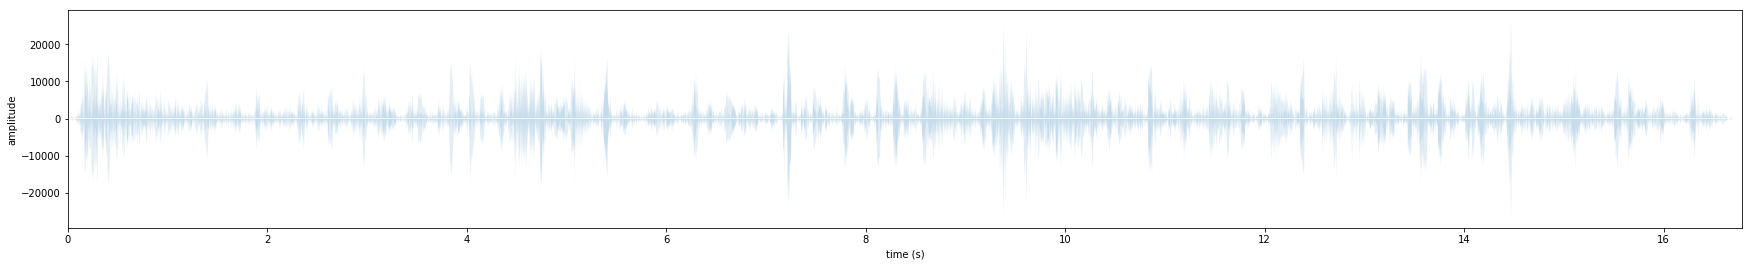

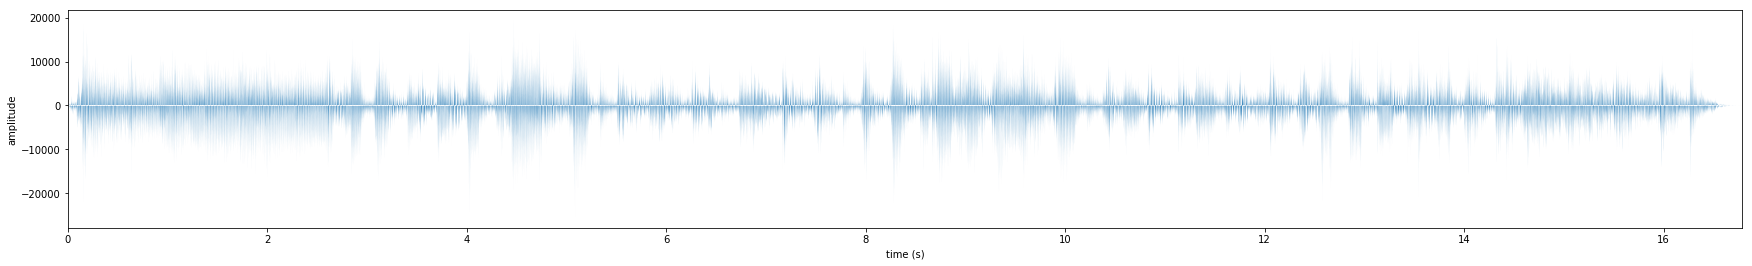

In [24]:
#Questions 3 & 4 - 2 Polyphase components - this part will take 2 and 3 as core values.
#Goal of these two questions is to implement 2 polyphase comp. and try them

#We'll define the shift operator (for the z^(-1) blocks) to a shift of the right

def shiftz(L0):
  #We use the L[0] slot as a tmp variable for the switches.
  L=deepcopy(L0)
  for i in range(len(L)-1):
    L[i+1],L[0] = L[i],L[i+1]
    return L
print(time.time())
###Polyphase 1###
x01 = downsampling(x*0.333333333333,3)
x02 = downsampling(shiftz(x*0.333333333333),3)
x03 = downsampling(shiftz(shiftz(x*0.333333333333)),3)

#Now those x0i are shortened, the filter part will be faster
y01 = signal.lfilter(h,[1],x01)*2
y02 = signal.lfilter(h,[1],x02)*2
y03 = signal.lfilter(h,[1],x03)*2

#We add them together, and upsample back, and shift it
y00 = []
for i in range(len(y01)):
  y00.append(y01[i]+y02[i]+y03[i])
x_hat0 = shiftz(upsampling(y00,2))

###Polyphase 2###
x11 = downsampling(x*0.333333333333,3)
x12 = downsampling(shiftz(x*0.333333333333),3)
x13 = downsampling(shiftz(shiftz(x*0.333333333333)),3)

#Now those x0i are shortened, the filter part will be faster
y11 = signal.lfilter(h,[1],x11)*2
y12 = signal.lfilter(h,[1],x12)*2
y13 = signal.lfilter(h,[1],x13)*2

#We add them together, and upsample back, and NOT shift it (as it is the second component for upsampling)
y00bis = []
for i in range(len(y11)):
  y00bis.append(y11[i]+y12[i]+y13[i])
x_hat1 = upsampling(y00bis,2) 

#Now we add back the two results into one output :
x_hat_polyph = []
for i in range(len(x_hat1)):
  x_hat_polyph.append((x_hat1[i]+x_hat0[i])/16)

print(time.time())
times_polyph = make_times(32000, x_hat_polyph)
plot_sound(x_hat_polyph, times_polyph)
plot_sound(resampled_x,times32)                 #To compare


#It is pretty clear I don't have the right coefficients for the in-between filtering. E0, E1, E2 and R0, R1, R2 are false
#even though I don't know why. I'll just pass on that as it is already sunday and I should hand my work over.

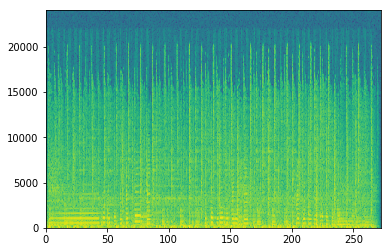

In [ ]:
if affich:
    plt.imshow(20*np.log10(np.abs(Xtilde[np.arange(0,L),:])), aspect='auto',interpolation='none',
               origin='lower', extent=[0, Nt * R / Fs + Nw / 2, 0, Fs/2])
    

## Overlap-add reconstruction

In [ ]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output